In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
from pathlib import Path
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p
import scipy.optimize

@dataclass
class WingSection:
    span_tip: float
    sweep: float
    chord_tip: float
    airfoil: asb.Airfoil
    init_point: np.ndarray
    init_chord: float

    def get_wing_tip_offset(self):
        return np.array([self.init_point[0] + (self.span_tip*np.tan(self.sweep)),
                         self.init_point[1] + self.span_tip,
                         0])
    
    def get_area(self):
        return (self.init_chord+self.chord_tip)*self.span_tip/2
    

def simulate_aircraft(wing_root_chord = 1, 
                      wing_tip_chord = 1,
                      wing_sweep = np.radians(40),
                      should_plot=False):
    
    wing_max_span = 3   

    wing_root_pnt = np.array([0, 0, 0])
    wing_sec1 = WingSection( span_tip=(wing_max_span)/2,
                            sweep = wing_sweep,
                            chord_tip = wing_tip_chord,
                            airfoil = asb.Airfoil("l1003"),
                            init_point = wing_root_pnt,
                            init_chord = wing_root_chord)

    def get_plane(xyz_ref=np.array([0, 0, 0])):
        return asb.Airplane(
            name="Dune Glider",
            xyz_ref=xyz_ref,  # CG location
            wings=[
                asb.Wing(
                    name="Main Wing",
                    symmetric=True,  # Should this wing be mirrored across the XZ plane?
                    xsecs=[  # The wing's cross ("X") sections
                        asb.WingXSec(  # Root
                            xyz_le = wing_root_pnt,  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                            chord = wing_root_chord,
                            twist = 0.0,  # degrees
                            airfoil = asb.Airfoil("l1003")
                        ),
                        asb.WingXSec(
                            xyz_le = wing_sec1.get_wing_tip_offset(),
                            chord = wing_sec1.chord_tip,
                            twist = 0,
                            airfoil=asb.Airfoil("l1003")
                        ),
                    ]
                )
            ]
        )

    ac = get_plane().aerodynamic_center() + np.array([0, 0, -1 ])
    airplane = get_plane(ac)

    if should_plot:
        airplane.draw_three_view()


    # AEROBUILDUP METHOD

    op_point = asb.OperatingPoint(
        atmosphere=asb.Atmosphere(altitude=0),
        velocity=8,  # m/s
    )

    xyz_ref = ac


    ab_op_point = op_point.copy()
    ab_op_point.alpha = np.linspace(-12, 25, 50)

    aerobuildup_aero = asb.AeroBuildup(
        airplane=airplane,
        op_point=ab_op_point,
        xyz_ref=xyz_ref
    ).run()

    aerobuildup_aero["alpha"] = ab_op_point.alpha
    aerobuildup_aero["CL/CD"] = np.divide(aerobuildup_aero["CL"], aerobuildup_aero["CD"])
    
# PLOT:
    if should_plot:
        fig, ax = plt.subplots(3, 1, figsize=(7, 9), dpi=100)

        for name, aero in {
            f"ASB {asb.__version__} AeroBuildup"                       : aerobuildup_aero,
        }.items():
            plt.sca(ax[0])
            p.plot_smooth(
                aero["alpha"],
                aero["CL"],
                label=name,
                function_of="x",
                alpha=0.7,
            )

            plt.sca(ax[1])
            p.plot_smooth(
                aero["alpha"],
                aero["CL/CD"],
                label=name,
                function_of="x",
                alpha=0.7,
            )

            plt.sca(ax[2])
            p.plot_smooth(
                aero["alpha"],
                aero["Cm"],
                label=name,
                function_of="x",
                alpha=0.7,
            )

        ax[0].set_title("Lift Polar")
        ax[0].set_xlabel("Angle of Attack $\\alpha$ [deg]")
        ax[0].set_ylabel("Lift Coefficient $C_L$ [-]")

        ax[1].set_title("Drag Polar")
        ax[1].set_xlabel("Angle of Attack $\\alpha$ [deg]")
        ax[1].set_ylabel("$C_L/C_D$ [-]")

        ax[2].set_title("Moment Polar")
        ax[2].set_xlabel("Angle of Attack $\\alpha$ [deg]")
        ax[2].set_ylabel("Moment Coefficient $C_m$ [-]")

        ax[0].legend(
            title="Analysis Method",
            fontsize=8,
            framealpha=0.2,
        )
        p.show_plot(legend=False)

    return aerobuildup_aero

In [2]:
def function_to_optimize(x):
    aero = simulate_aircraft(wing_root_chord = x[0],
                             wing_tip_chord = x[1],
                             wing_sweep = x[2])
    
    # Calculate optimization function

    # We maximize the CL/CD
    max_clcd = np.max(aero['CL/CD'])
    max_clcd_alpha = np.argmax(aero['CL/CD'])

    # CM should be below zero in all alpha above zero. Same in the opposite direction 
    # We can create a "score" using a sigmoid function
    npoints = len(aero['Cm'])
    sum_score_cm = 0
    for i in range(npoints):
        if aero['alpha'][i] >= max_clcd_alpha:
            y = 1 / (1 + np.exp((aero['Cm'][i]-0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)
        else:
            y = 1 / (1 + np.exp(-(aero['Cm'][i]+0.05)*100))
            sum_score_cm += y
            # print(aero['alpha'][i],", ", aero['Cm'][i], ", ", y)

    # If the score is 1, it is perfect
    normalized_avg_cm_score = sum_score_cm/npoints
    normalized_avg_cm_score = 1

    cl_alpha_in_max_clcd = aero['CL'][max_clcd_alpha]
    cm_alpha_in_max_clcd = aero['Cm'][max_clcd_alpha]

    # We expect the Cm around the max CL/CD point is near zero as possible, so we use a d(tanh)/dx function
    score_cm_alpha_max_clcd = 1-np.power(cm_alpha_in_max_clcd*(1/0.2),2)

    score = max_clcd*normalized_avg_cm_score*cl_alpha_in_max_clcd*score_cm_alpha_max_clcd
    return -(score)

In [3]:
#               wing_root_chord   wing_tip_chord   wing_sweep
init_values  = [1,                1,                np.radians(0)]
bound_values = [(0.05, 2),        (0.05, 2),       (np.radians(0), np.radians(45))]

minimizer_kwargs = {"method": "L-BFGS-B", "bounds":bound_values, 'options':{"disp": True}}
xopt = scipy.optimize.basinhopping(function_to_optimize, x0=init_values, niter=20, minimizer_kwargs=minimizer_kwargs)
# xopt = scipy.optimize.minimize(fun=function_to_optimize, 
#                                 x0=init_values,
#                                 bounds=bound_values,
#                                 method="TNC",
#                                 options={"disp": True}
#                                 )


['requested number of basinhopping iterations completed successfully']
[1.28481812 0.05       0.2976006 ]
-6.030721195042345
wing_root_chord: 1.2848181151542593
wing_tip_chord: 0.05
wing_sweep: 17.051258191255346


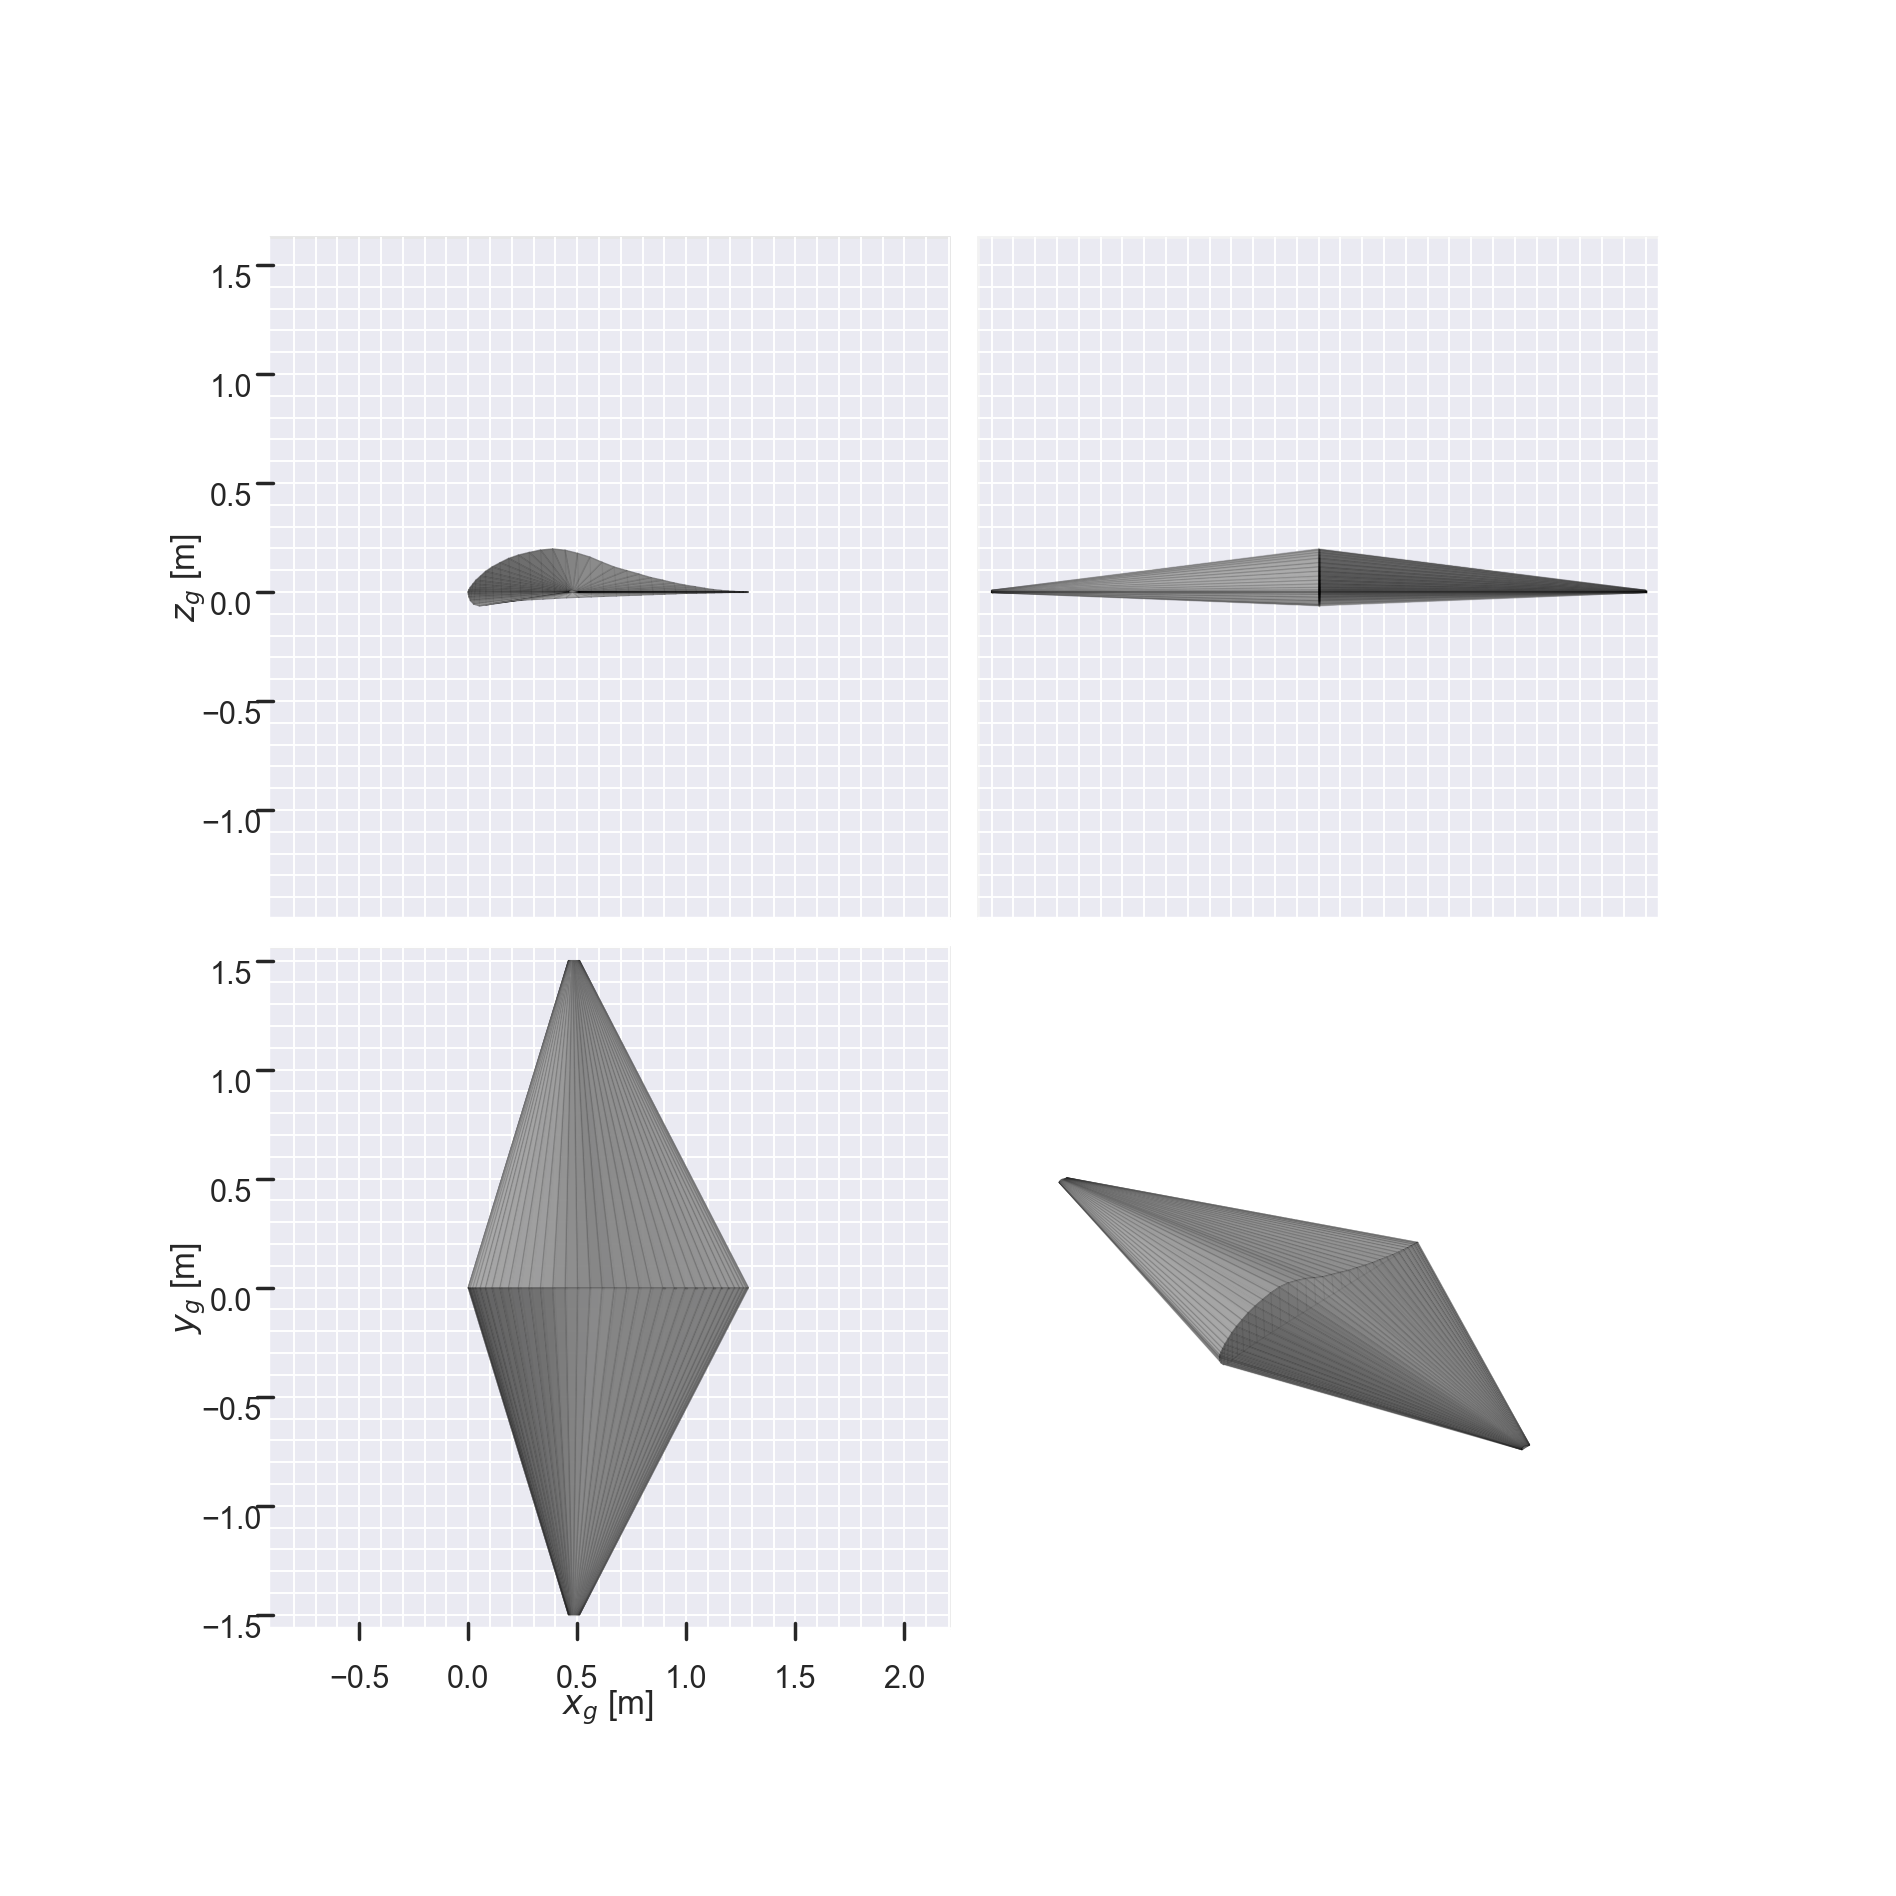

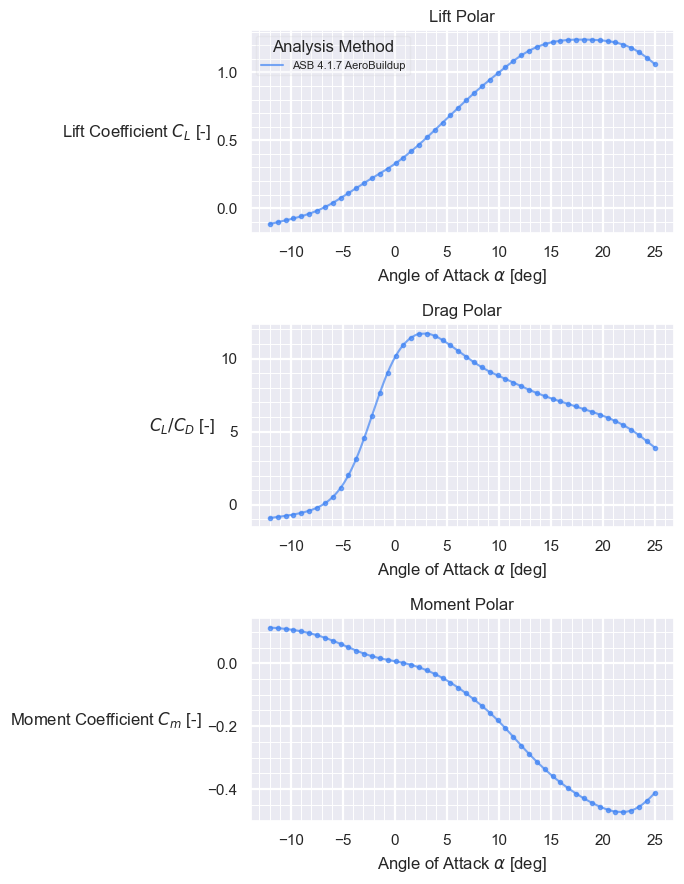

In [4]:
print(xopt.message)
print(xopt.x)
print(xopt.fun)
print(f"wing_root_chord: {xopt.x[0]}")
print(f"wing_tip_chord: {xopt.x[1]}")
print(f"wing_sweep: {xopt.x[2]*180/np.pi}")
aero = simulate_aircraft(wing_root_chord = xopt.x[0],
                            wing_tip_chord = xopt.x[1],
                            wing_sweep = xopt.x[2],
                            should_plot=True)